In [1]:
import torch

def generate_sine_waves(frequency, amplitude, phase_difference, sampling_rate, duration):
    """
    Generate two sine wave signals with a given phase difference using PyTorch tensors.

    Parameters:
    - frequency: The frequency of the sine waves in Hz.
    - amplitude: The amplitude of the sine waves.
    - phase_difference: The phase difference between the two sine waves in radians.
    - sampling_rate: The number of samples per second (Hz).
    - duration: The duration of the signals in seconds.

    Returns:
    - signal1: The first sine wave signal (PyTorch tensor).
    - signal2: The second sine wave signal with the specified phase difference (PyTorch tensor).
    """
    # Create a time vector
    t = torch.arange(0, duration, 1 / sampling_rate)
    theta = torch.randint(1, 180, (1,))
    # Generate the first sine wave signal
    signal1 = amplitude * torch.sin(2 * torch.pi * frequency * t + theta)
    # Generate the second sine wave signal with a phase difference
    signal2 = amplitude * torch.sin(2 * torch.pi * frequency * t + theta + phase_difference)
    return signal1, signal2

def get_samples(N=5000, transpose=False):
    X = []
    Y = []
    # Example usage
    frequency = 1  # Hz
    amplitude = 1.0  # Unit amplitude
    sampling_rate = 360  # Hz
    duration = 1.0  # 1 second
    for i in range(N):
        temp = torch.randint(1, 180, (1,))
        phase_difference = torch.pi / 180 * temp  
        Y.append(temp)
        signal1, signal2 = generate_sine_waves(frequency, amplitude, phase_difference, sampling_rate, duration)
        X.append(torch.cat([signal1.unsqueeze(0), signal2.unsqueeze(0)], dim=0).transpose(0,1).unsqueeze(0))
    if transpose:
        return torch.cat(X, dim=0).transpose(1,2), torch.tensor(Y, dtype=torch.float)
    return torch.cat(X, dim=0), torch.tensor(Y, dtype=torch.float)

def acc(pred, label, epsilon=3):
    out=(torch.sum(torch.abs(pred-label)<=epsilon).item()/(label.size(0))*100)
    print(f"epsilon = {epsilon}, accuracy = {out:4f}%")
    return out

def mse(pred, label):
    out=(torch.mean((pred-label)**2).item())
    print(f"Mean square error = {out:4f}")
    return out

Text(145.0, 0.1, 'ground truth')

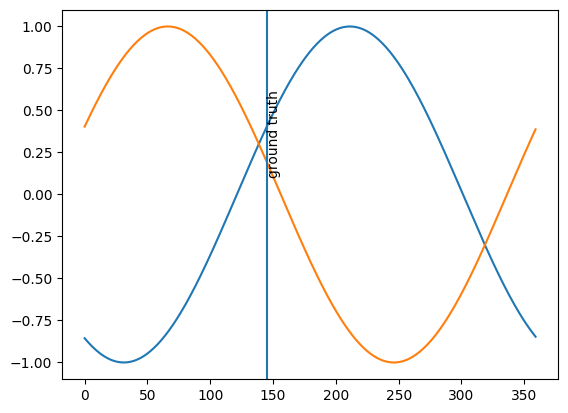

In [2]:
import matplotlib.pyplot as plt

inputs, labels = get_samples(1)
input = inputs.detach().cpu().numpy()

plt.plot(input.squeeze()[:,0])
plt.plot(input.squeeze()[:,1])
plt.axvline(labels.item(), linestyle='-', label='ground truth')
plt.text(labels.item(), 0.1, 'ground truth', rotation=90, verticalalignment='bottom')

## **ANN**

In [24]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define the spiking neural network
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        # Define layers
        
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2*360, 180, bias=False),
            nn.Sigmoid(),
            nn.Linear(180, 180, bias=False)
            )

    def forward(self, x: torch.Tensor):
        return self.layer(x)

    def save(self):
        torch.save(self.state_dict(), 'model(a).pth')

    def load(self):
        self.load_state_dict(torch.load('model(a).pth'))
        

inputs, labels = get_samples(10000)

# Create a dataset and dataloader
dataset = TensorDataset(inputs.to(device), labels.to(device))
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

# Initialize the network
ann = ANN().to(device)

# Define the loss function (CrossEntropyLoss) and optimizer (Adam)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ann.parameters(), lr=0.001)


cpu


In [25]:
# Number of epochs
n_epochs = 100
ann.train()
T=100
# Training loop
for epoch in range(n_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        out_fr = ann(inputs)
        
        # print(out_fr, labels.long())
        # break
        loss = criterion(out_fr, labels.long())
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        # break
        if i % 10 == 9:  # Print every 10 batches
            print(f'Epoch [{epoch + 1}/{n_epochs}], Step [{i + 1}/{len(dataloader)}], Loss: {running_loss / 10:.4f}')
            running_loss = 0.0
print('Training finished.')
ann.save()

Epoch [1/100], Step [10/10], Loss: 5.2205
Epoch [2/100], Step [10/10], Loss: 5.1790
Epoch [3/100], Step [10/10], Loss: 5.1711
Epoch [4/100], Step [10/10], Loss: 5.1646
Epoch [5/100], Step [10/10], Loss: 5.1612
Epoch [6/100], Step [10/10], Loss: 5.1579
Epoch [7/100], Step [10/10], Loss: 5.1558
Epoch [8/100], Step [10/10], Loss: 5.1534
Epoch [9/100], Step [10/10], Loss: 5.1514
Epoch [10/100], Step [10/10], Loss: 5.1492
Epoch [11/100], Step [10/10], Loss: 5.1483
Epoch [12/100], Step [10/10], Loss: 5.1461
Epoch [13/100], Step [10/10], Loss: 5.1455
Epoch [14/100], Step [10/10], Loss: 5.1438
Epoch [15/100], Step [10/10], Loss: 5.1411
Epoch [16/100], Step [10/10], Loss: 5.1408
Epoch [17/100], Step [10/10], Loss: 5.1395
Epoch [18/100], Step [10/10], Loss: 5.1377
Epoch [19/100], Step [10/10], Loss: 5.1361
Epoch [20/100], Step [10/10], Loss: 5.1340
Epoch [21/100], Step [10/10], Loss: 5.1318
Epoch [22/100], Step [10/10], Loss: 5.1316
Epoch [23/100], Step [10/10], Loss: 5.1289
Epoch [24/100], Step

In [26]:

inputs, labels = get_samples(1000)

# Create a dataset and dataloader
dataset = TensorDataset(inputs.to(device), labels.to(device))
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

# Initialize the network
ann = ANN().to(device)
ann.load()

# Number of epochs
n_epochs = 100

pred = []
l = []
# Training loop
running_loss = 0.0
with torch.no_grad():
    for i, (X, Y) in enumerate(dataloader):
        ann.eval()
        # Forward pass
        out_fr = ann(X)
        pred.append(torch.argmax(out_fr, dim=1))
        l.append(Y)
pred = torch.cat(pred, dim=0)
l = torch.cat(l, dim=0)
_=acc(pred, l)
_=mse(pred, l)

epsilon = 3, accuracy = 26.500000
Mean square error = 102.697998


tensor([103])
122.0 torch.Size([360, 2])


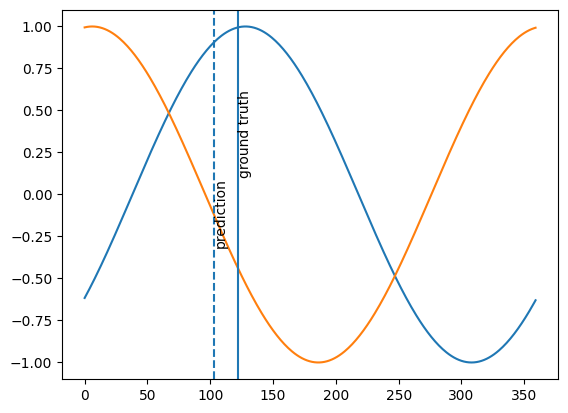

In [29]:
import matplotlib.pyplot as plt

inputs, labels = get_samples(1)
input = inputs.detach().cpu().numpy()

with torch.no_grad():
    ann.eval()
    out_fr = ann(inputs)
    out1 = torch.argmax(out_fr, dim=1)
    print(out1)

print(labels.item(), inputs.squeeze().shape)

plt.plot(input.squeeze()[:,0])
plt.plot(input.squeeze()[:,1])

plt.axvline(labels.item(), linestyle='-', label='ground truth')
plt.text(labels.item(), 0.1, 'ground truth', rotation=90, verticalalignment='bottom')
plt.axvline(out1.item(), linestyle='--', label='prediction')
plt.text(out1.item(), 0.1, 'prediction', rotation=90, verticalalignment='top')
plt.show()

## **model 1**(time optimized)

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from spikingjelly.activation_based import neuron, encoding, functional, surrogate, layer

device = torch.device("cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the spiking neural network
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        # Define layers
        
        self.layer = nn.Sequential(
            layer.Flatten(),
            layer.Linear(2*360, 180, bias=False),
            neuron.LIFNode(tau=1.5),
            layer.Flatten(),
            layer.Linear(180, 180, bias=True)
            )

    def forward(self, x: torch.Tensor):
        out = x.transpose(0,1).contiguous()
        out = self.layer[0:2](out)
        out = self.layer[2](out.transpose(0,1).contiguous())
        out = self.layer[3:](out.transpose(0,1).contiguous())
        return out

    def save(self):
        torch.save(self.state_dict(), 'model(o).pth')

    def load(self):
        self.load_state_dict(torch.load('model(o).pth'))


# Initialize the network
snn = SNN().to(device)

# Define the loss function (CrossEntropyLoss) and optimizer (Adam)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(snn.parameters(), lr=0.001)

In [32]:
# Number of epochs
batch=1000
n_epochs = 100
snn.train()
T=100
# Training loop
encoder = encoding.PoissonEncoder()
for epoch in range(n_epochs):
    running_loss = 0.0
    inputs, labels = get_samples(10000)
    
    for count, i in enumerate(range(0,inputs.size(0), batch)):
        x, y = inputs[i:i+batch, :, :], labels[i:i+batch]           # X: batch, seq, dim
        # Reset the network states (important for spiking neural networks)
        functional.reset_net(snn)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # concatinating time steps
        temp = torch.cat([(x[:,j].unsqueeze(0)+1)/2 for j in range(x.size(1))], dim=0) # X: seq, batch, dim
        temp = encoder(temp)
        # print(temp.shape)
        
        # Forward pass
        out_fr = snn(temp)

        # print(out_fr,  y.long().shape)
        # break
        loss = criterion(out_fr, y.long())
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        # break
        # print(count)
        if count % 10 == 9:  # Print every 10 batches
            print(f'Epoch [{epoch + 1}/{n_epochs}], Step [{i + 1}/{inputs.size(0)}], Loss: {running_loss / 10:.4f}')
            running_loss = 0.0
print('Training finished.')
snn.save()

Epoch [1/100], Step [9001/10000], Loss: 3.3428
Epoch [2/100], Step [9001/10000], Loss: 3.3282
Epoch [3/100], Step [9001/10000], Loss: 3.3281
Epoch [4/100], Step [9001/10000], Loss: 3.3208
Epoch [5/100], Step [9001/10000], Loss: 3.3194
Epoch [6/100], Step [9001/10000], Loss: 3.3185
Epoch [7/100], Step [9001/10000], Loss: 3.3216
Epoch [8/100], Step [9001/10000], Loss: 3.3093
Epoch [9/100], Step [9001/10000], Loss: 3.3191
Epoch [10/100], Step [9001/10000], Loss: 3.3099
Epoch [11/100], Step [9001/10000], Loss: 3.3075
Epoch [12/100], Step [9001/10000], Loss: 3.3076
Epoch [13/100], Step [9001/10000], Loss: 3.3069
Epoch [14/100], Step [9001/10000], Loss: 3.3092
Epoch [15/100], Step [9001/10000], Loss: 3.3037
Epoch [16/100], Step [9001/10000], Loss: 3.3063
Epoch [17/100], Step [9001/10000], Loss: 3.3021
Epoch [18/100], Step [9001/10000], Loss: 3.3115
Epoch [19/100], Step [9001/10000], Loss: 3.3099
Epoch [20/100], Step [9001/10000], Loss: 3.2991
Epoch [21/100], Step [9001/10000], Loss: 3.2943
E

In [33]:

inputs, labels = get_samples(1000)

# Initialize the network
snn = SNN().to(device)
snn.load()

pred = []
l = []
# Training loop
running_loss = 0.0
with torch.no_grad():    
    for count, i in enumerate(range(0, inputs.size(0), batch)):
        x, y = inputs[i:i+batch, :, :], labels[i:i+batch]           # X: batch, seq, dim
        # Reset the network states (important for spiking neural networks)
        functional.reset_net(snn)
        
        # concatinating time steps
        temp = torch.cat([(x[:,j].unsqueeze(0)+1)/2 for j in range(x.size(1))], dim=0) # X: seq, batch, dim
        temp = encoder(temp)
        # print(temp.shape)
        
        # Forward pass
        out_fr = snn(temp)

        pred.append(torch.argmax(out_fr, dim=1))
        l.append(y)
pred = torch.cat(pred, dim=0)
l = torch.cat(l, dim=0)
_=acc(pred, l)
_=mse(pred, l)

epsilon = 3, accuracy = 39.000000
Mean square error = 36.948002


torch.Size([360, 1, 2])
tensor([106])
torch.Size([1, 180])
110.0 torch.Size([360, 2])


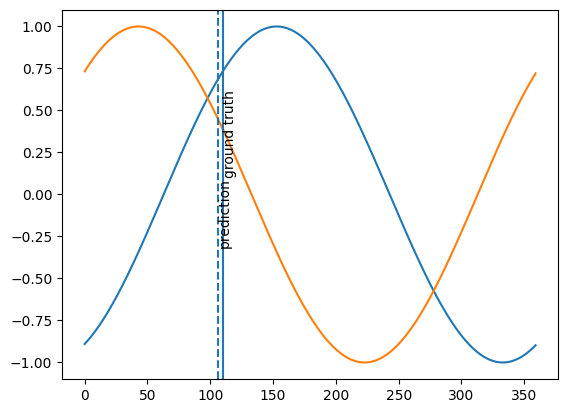

In [48]:
import matplotlib.pyplot as plt

x, labels = get_samples(1)
input = x.detach().cpu().numpy()

with torch.no_grad():
    snn.eval()
    functional.reset_net(snn)
    temp = torch.cat([(x[:,j].unsqueeze(0)+1)/2 for j in range(x.size(1))], dim=0) # X: seq, batch, dim
    temp = encoder(temp)

    # Forward pass
    out_fr = snn(temp)
    out1 = torch.argmax(out_fr, dim=1)
    
print(labels.item(), x.squeeze().shape)

plt.plot(input.squeeze()[:,0])
plt.plot(input.squeeze()[:,1])

plt.axvline(labels.item(), linestyle='-', label='ground truth')
plt.text(labels.item(), 0.1, 'ground truth', rotation=90, verticalalignment='bottom')
plt.axvline(out1.item(), linestyle='--', label='prediction')
plt.text(out1.item(), 0.1, 'prediction', rotation=90, verticalalignment='top')
plt.show()


## **model 2**(optimized for results)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from spikingjelly.activation_based import neuron, encoding, functional, surrogate, layer

device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define the spiking neural network
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        # Define layers
        
        self.layer = nn.Sequential(
            layer.Linear(2*360, 180, bias=True),
            neuron.LIFNode(tau=2.0, surrogate_function=surrogate.ATan()),
            layer.Linear(180, 180, bias=False)
            )

    def forward(self, x: torch.Tensor):
        return self.layer(x)

    def save(self):
        torch.save(self.state_dict(), 'model(m).pth')

    def load(self):
        self.load_state_dict(torch.load('model(m).pth'))
        

inputs, labels = get_samples(10000)

# Create a dataset and dataloader
dataset = TensorDataset(inputs.to(device), labels.to(device))
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

# Initialize the network
snn = SNN().to(device)

cuda


In [20]:

# Define the loss function (CrossEntropyLoss) and optimizer (Adam)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(snn.parameters(), lr=0.001)

# Number of epochs
n_epochs = 100
snn.train()
T=100
# Training loop
encoder = encoding.PoissonEncoder()
for epoch in range(n_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader):
        # Reset the network states (important for spiking neural networks)
        b, n, d = inputs.size()
        functional.reset_net(snn)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        out_fr = 0.
        for t in range(T):
            # encoding full matrix of the input as poisson
            # print((inputs).view(b,n*d).shape, inputs.shape)
            encoded_img = encoder(inputs.view(b,n*d))
            out_fr += snn(encoded_img)
        
        # averaging the outputs
        out_fr = out_fr / T
        
        # print(out_fr, labels.long())
        # break
        loss = criterion(out_fr, labels.long())
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        # break
        if i % 10 == 9:  # Print every 10 batches
            print(f'Epoch [{epoch + 1}/{n_epochs}], Step [{i + 1}/{len(dataloader)}], Loss: {running_loss / 10:.4f}')
            running_loss = 0.0
print('Training finished.')
snn.save()

Epoch [1/100], Step [10/10], Loss: 3.2284
Epoch [2/100], Step [10/10], Loss: 3.1925
Epoch [3/100], Step [10/10], Loss: 3.1654
Epoch [4/100], Step [10/10], Loss: 3.1417
Epoch [5/100], Step [10/10], Loss: 3.1181
Epoch [6/100], Step [10/10], Loss: 3.0963
Epoch [7/100], Step [10/10], Loss: 3.0763
Epoch [8/100], Step [10/10], Loss: 3.0561
Epoch [9/100], Step [10/10], Loss: 3.0362
Epoch [10/100], Step [10/10], Loss: 3.0178
Epoch [11/100], Step [10/10], Loss: 2.9993
Epoch [12/100], Step [10/10], Loss: 2.9816
Epoch [13/100], Step [10/10], Loss: 2.9639
Epoch [14/100], Step [10/10], Loss: 2.9469
Epoch [15/100], Step [10/10], Loss: 2.9305
Epoch [16/100], Step [10/10], Loss: 2.9141
Epoch [17/100], Step [10/10], Loss: 2.8991
Epoch [18/100], Step [10/10], Loss: 2.8849
Epoch [19/100], Step [10/10], Loss: 2.8707
Epoch [20/100], Step [10/10], Loss: 2.8560
Epoch [21/100], Step [10/10], Loss: 2.8419
Epoch [22/100], Step [10/10], Loss: 2.8290
Epoch [23/100], Step [10/10], Loss: 2.8161
Epoch [24/100], Step

In [21]:
inputs, labels = get_samples(1000)

# Create a dataset and dataloader
dataset = TensorDataset(inputs.to(device), labels.to(device))
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

# Initialize the network
snn = SNN().to(device)
snn.load()

# Number of epochs
n_epochs = 100

pred = []
l = []
# Training loop
running_loss = 0.0
with torch.no_grad():
    for i, (X, Y) in enumerate(dataloader):
        b, n, d = X.size()
        snn.eval()
        functional.reset_net(snn)

        # Forward pass
        out_fr = 0.
        for t in range(T):
            # encoding full matrix of the input as poisson
            encoded_img = encoder(X.view(b,n*d))
            out_fr += snn(encoded_img)
        
        # averaging the outputs
        out_fr = out_fr / T
        pred.append(torch.argmax(out_fr, dim=1))
        l.append(Y)
pred = torch.cat(pred, dim=0)
l = torch.cat(l, dim=0)
_=acc(pred, l)
_=mse(pred, l)

epsilon = 3, accuracy = 91.900000%
Mean square error = 4.004000


tensor([123], device='cuda:0')
123.0 torch.Size([360, 2])


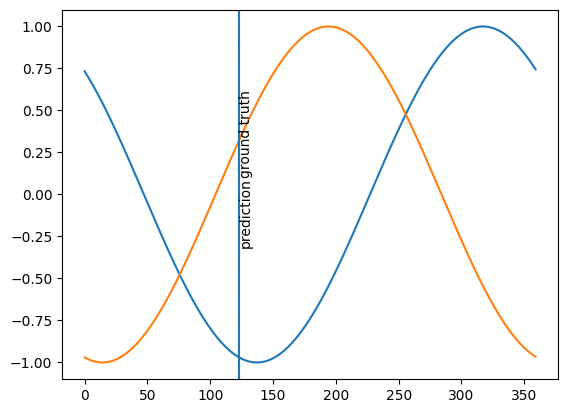

In [23]:
import matplotlib.pyplot as plt

inputs, labels = get_samples(1)
input = inputs.detach().cpu().numpy()

with torch.no_grad():
    snn.eval()
    functional.reset_net(snn)
    out_fr = 0.
    b, n, d = inputs.size()
    for t in range(T):
        # print('f')
        encoded_img = encoder(inputs.view(b, n*d).to(device))
        out_fr += snn(encoded_img)
    out_fr = out_fr / T
    out1 = torch.argmax(out_fr, dim=1)
    print(out1)
    
print(labels.item(), inputs.squeeze().shape)

plt.plot(input.squeeze()[:,0])
plt.plot(input.squeeze()[:,1])

plt.axvline(labels.item(), linestyle='-', label='ground truth')
plt.text(labels.item(), 0.1, 'ground truth', rotation=90, verticalalignment='bottom')
plt.axvline(out1.item(), linestyle='--', label='prediction')
plt.text(out1.item(), 0.1, 'prediction', rotation=90, verticalalignment='top')
plt.show()